In [55]:
# Import dependencies
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bisect import bisect_left, bisect_right
import os
import seaborn as sns
import typing
from datetime import date, timedelta, datetime
from utils import convert_from_json_to_df

data source: https://derivative.credit-suisse.com/ch/ch/en/detail/autocallable-brc-lonza-sika-8-00-p-a/CH1253871557/125387155

[*********************100%%**********************]  2 of 2 completed


<Axes: xlabel='Date'>

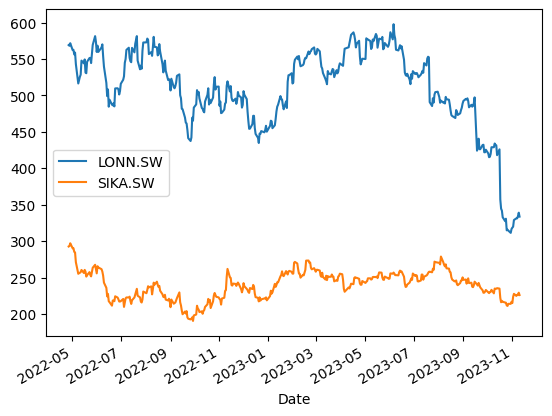

In [56]:
# Define the ticker list
import yfinance as yf
tickers_list = ['SIKA.SW', 'LONN.SW']

# Fetch the data
data = yf.download(tickers_list,'2022-04-27')['Adj Close']
data.plot()

In [57]:
data

,LONN.SW,SIKA.SW
Date,,
2022-04-27,569.189392,292.776306
2022-04-28,568.200867,293.368774
2022-04-29,571.759583,297.219788
2022-05-02,562.269714,290.307678
2022-05-03,562.665222,290.406433
...,...,...
2023-11-06,331.399994,225.000000
2023-11-07,331.399994,226.399994
2023-11-08,334.399994,226.500000


In [58]:
barriers = [329.76, 144.24]

In [59]:
print(data[data['LONN.SW'] <= barriers[0]]['LONN.SW'])
print(data[data['SIKA.SW'] <= barriers[1]]['SIKA.SW'])

Date
2023-10-23    327.600006
2023-10-25    315.000000
2023-10-26    315.899994
2023-10-27    314.600006
2023-10-30    311.500000
2023-10-31    316.799988
2023-11-01    318.600006
2023-11-02    320.000000
2023-11-03    329.100006
Name: LONN.SW, dtype: float64
Series([], Name: SIKA.SW, dtype: float64)


In [60]:
## specs
denomination = 1000.0
barrier = 0.6
coupon_rate = 0.08/4
coupon = coupon_rate*denomination

initial_fixing_date = datetime(2023,4,27)
final_fixing_date = datetime(2024,7,30)
maturity_date = datetime(2024,8,5)

issue_date = datetime(2023,4,28)

coupon_payment_dates = [
    datetime(2023,8,5),
    datetime(2023,11,5),
    datetime(2024,2,5),
    datetime(2024,5,5),
    datetime(2024,8,5),
]

early_redemption_observation_dates = [
    datetime(2023,10,27),
    datetime(2023,1,27),
    datetime(2023,4,27),
]
early_redemption_dates = [
    datetime(2023,11,5),
    datetime(2024,2,5),
    datetime(2024,5,5),
]

early_redemption_level = stock_init_price = [549.60, 240.40]

converstion_ratios = [1.8195,4.1597]


In [61]:
from bisect import bisect_left

def BarrierReverseConvertible(params: typing.Dict, current_date: str, St: np.array):
    r = params.get('interest_rate')
    autocall_on = params.get('autocall')
    current_date = datetime.strptime(current_date, format)
    index = bisect_left(coupon_payment_dates, current_date)
    dates = coupon_payment_dates[index:]
    discounted_coupons = []
    for d in dates:
        discounted_c = coupon * np.exp(-r*((d - current_date).days))
        discounted_coupons.append(discounted_c)
    ## no early redemption ##
    V = (sum(discounted_coupons) + denomination*np.exp(-r*(maturity_date-current_date).days)*int(min(St[:,0])>barriers[0] and min(St[:,1])>barrier[1])
            + sum(discounted_coupons) + converstion_ratios[0]*min(St[:,0])*int(min(St[:,0])<=barrier[0])
            + sum(discounted_coupons) + converstion_ratios[0]*min(St[:,1])*int(min(St[:,1])<=barrier[1])
            + sum(discounted_coupons)*int(St[:,0][-1] == 0 or St[:,1][-1] == 0))
    if autocall_on:
        ## early redemption ##
        dates = sorted(list(set(dates) & set(early_redemption_observation_dates)))
        mn = [min([St.loc[date.strftime(format)][0] for date in dates]), min([St.loc[date.strftime(format)][1] for date in dates])]
        V = ( V * (1 -int(mn[0] >= early_redemption_level[0] and mn[1] >= early_redemption_level[1])) 
            + (sum(discounted_coupons) + denomination*np.exp(-r*(maturity_date-current_date).days))*int(mn[0] >= early_redemption_level[0] and mn[1] >= early_redemption_level[1]) 
        )
    return V

In [62]:
from model import SingleAssetGBM
params = {
    'name': 'LONN.SW',
    'maturity_date': '2024-08-05',
    'simulations': 1000,
    'window_size': 365,
    'prediction_range': ('2023-08-09', '2023-11-09'),
    'interest_rate_model': None, 
    'volatiliy_model': None,
    'variance_reduction': None,
}

current_date = '2023-08-09'
lonn = SingleAssetGBM(params)
path = lonn.fit(current_date, data['LONN.SW']).generate_paths()
path.shape

ImportError: cannot import name 'SingleAssetGBM' from 'model' (/Users/maffinnn/Desktop/mh4518/code/sy/model.py)

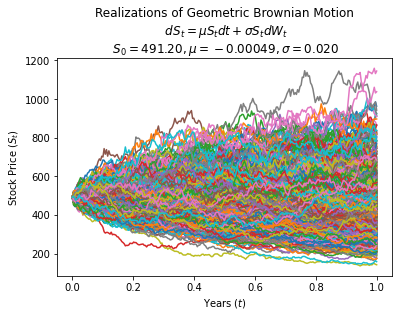

In [ ]:
tt = np.full(shape=path.T.shape, fill_value=np.linspace(0,1,259)).T
plt.plot(tt, path)
plt.xlabel("Years $(t)$")
plt.ylabel("Stock Price $(S_t)$")
plt.title(
    f"Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {lonn.S0:.2f}, \mu = {lonn.mu:.5f}, \sigma = {lonn.sigma:.3f}$"
)
plt.show()

In [ ]:
product_price = convert_from_json_to_df('data/product/price.json')
product_price = product_price.set_index('date')
product_price['price'] = product_price['value'] / 100.0 * denomination

In [ ]:
product_price

,value,price
date,,
2023-10-30,60.75,607.5
2023-10-27,61.30,613.0
2023-10-26,61.57,615.7
2023-10-25,61.54,615.4
2023-10-24,64.23,642.3
...,...,...
2023-05-05,98.82,988.2
2023-05-04,98.51,985.1
2023-05-03,98.09,980.9


### Interest rate model
- Vasicek: $dr_t = a (b - r_t) dt + \sigma r_t dW_t$
- CIR: $dr_t = a (b - r_t) dt + \sigma \sqrt{r_t} dW_t$ => not suitable in our case because switzerland's interest rate is negative in 2022.
- data from: https://www.investing.com/rates-bonds/switzerland-30-year-bond-yield-historical-data

In [ ]:
path = '../../data/bond'

bonds = None
for file in os.listdir(path):
   df = pd.read_csv(os.path.join(path, file))[['Date','Price']]
   df.rename(columns={'Price':str(int((file.split(' ')[1]).split('-')[0])*7)+'-Day'}, inplace=True)
   df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%Y')
   df = df.set_index('Date').iloc[::-1]
   if bonds is None:
      bonds = df
   else:
      bonds = pd.concat([bonds, df], axis=1)
bonds = bonds.interpolate()

In [ ]:
bonds = bonds.reindex(sorted(bonds.columns, key=lambda x: int(x.split('-')[0])), axis=1)
bonds

,7-Day,28-Day,56-Day,84-Day,168-Day,336-Day,672-Day
Date,,,,,,,
2022-01-01,-1.00,-0.80,-0.78,-0.95,-0.90,-0.80,NaN
2022-01-02,-1.00,-0.77,-0.76,-0.90,-0.85,-0.80,NaN
2022-01-03,-0.88,-0.84,-0.87,-0.86,-0.85,-0.80,-0.700
2022-01-04,-0.90,-0.86,-0.74,-0.86,-0.85,-0.73,-0.729
2022-01-05,-0.94,-0.87,-0.80,-0.87,-0.85,-0.73,-0.715
...,...,...,...,...,...,...,...
2023-11-05,1.60,1.60,1.64,1.62,1.60,1.70,1.330
2023-11-06,1.58,1.59,1.64,1.61,1.65,1.67,1.326
2023-11-07,1.58,1.59,1.63,1.61,1.65,1.67,1.338


difference between current date and final fixing date:  266
1.6616666666666666


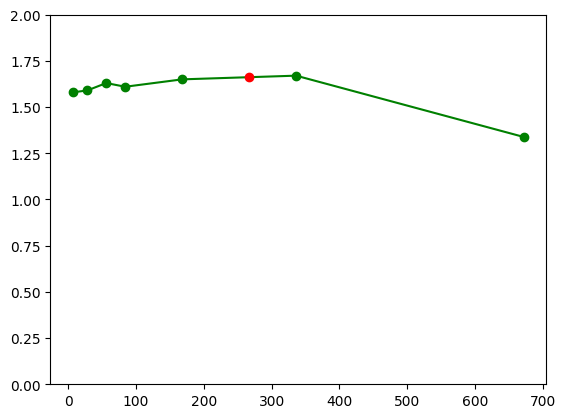

In [ ]:
current_date = '2023-11-07'
final_fixing_date = '2024-07-30'
format = '%Y-%m-%d'
tdelta = (datetime.strptime(final_fixing_date, format) - datetime.strptime(current_date, format)).days
print("difference between current date and final fixing date: ", tdelta)

X = [int(colname.split('-')[0]) for colname in bonds.columns]
Y = bonds.loc[current_date].to_list()

interpolated_y = np.interp(tdelta,X,Y)
print(interpolated_y)
plt.ylim((0,2))
plt.plot(X, Y, "og-", tdelta, interpolated_y, "or");


In [ ]:
def constant_r(date: str):
    final_fixing_date = '2024-07-30'
    format = '%Y-%m-%d'
    tdelta = (datetime.strptime(final_fixing_date, format) - datetime.strptime(date, format)).days
    X = [int(colname.split('-')[0]) for colname in bonds.columns]
    Y = bonds.loc[current_date].to_list()
    interpolated_y = np.interp(tdelta,X,Y)
    return interpolated_y

[]

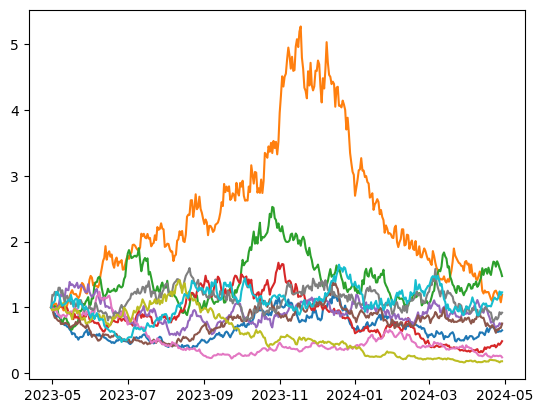

In [ ]:
from model import genGBM, future_payouts, rnv
#viz of price paths
N = 10
pathArr = []
plt.figure()
for i in range(N):
    pathArr.append(genGBM(1, date.fromisoformat('2023-04-30'), 0.1, 1, 1/365, 365))
    plt.plot(pathArr[i]['date'], pathArr[i]['price'])
plt.plot()

In [68]:
t_0 = date.fromisoformat('2023-04-27')
today = date.fromisoformat('2023-08-01')
final_fixing_date = date.fromisoformat('2024-07-30')
r = 0.05
payoffs = []
df_end1_n = []
df_end2_n = []
N = 10
for i in range(N):
    df_path1 = genGBM(1, t_0, 0.04, 0.1, 1/365, 465)
    df_path2 = genGBM(1, t_0, 0.04, 0.1, 1/365, 465)
    df_end1_n.append(df_path1['price'].to_numpy()[-1])
    df_end2_n.append(df_path2['price'].to_numpy()[-1])
    df_payouts = future_payouts(df_path1, df_path2, False)
    v = rnv(df_payouts, today, r)
    payoffs.append(v)
print(payoffs)
print(df_end1_n)
print(df_end2_n)

[1026.5197929497006, 1033.7864463643152, 1026.5197929497006, 1048.0508022778185, 1026.5197929497006, 1026.5197929497006, 1026.5197929497006, 1048.0508022778185, 1048.0508022778185, 1026.5197929497006]
[1.1519493035310506, 1.1148580530193208, 1.0349924883153425, 0.9212749080287843, 1.2149700479336727, 1.1938870787708975, 1.0647156079627118, 0.906901995370184, 0.7895727755232146, 1.0221803474438775]
[1.0710891552822062, 1.0844480761983293, 1.3239004102489766, 0.9299951808753721, 0.952176736021611, 1.0647775686577692, 1.1078621789234602, 0.9858200807246336, 0.9536648323041261, 0.9727648407600776]


In [65]:
s_01  = 1
s_02 = 1.2
mu1 = s_01 * np.exp(r*(final_fixing_date - today).days/365)
mu2 = s_02 * np.exp(r*(final_fixing_date - today).days/365)
print(mu1, mu2)

1.0511270965000248 1.2613525158000296


In [90]:
from sklearn.linear_model import LinearRegression

def control_variates(df_end1_n, df_end2_n, mu1, mu2, df_payouts_n):
    ratio = 0.5
    N = len(df_payouts_n)
    reg_len = int(ratio*N)
    df_end1_n_reg = df_end1_n[:reg_len]
    df_end1_n_est = df_end1_n[reg_len:]
    df_end2_n_reg = df_end2_n[:reg_len]
    df_end2_n_est = df_end2_n[reg_len:]
    df_n_reg = np.array([df_end1_n_reg, df_end2_n_reg])
    df_n_est = np.array([df_end1_n_est, df_end2_n_est])
    df_payouts_n_reg = df_payouts_n[:reg_len]
    df_payouts_n_est = df_payouts_n[reg_len:]

    reg = LinearRegression().fit(np.transpose(df_n_reg), df_payouts_n_reg)
    coef = reg.coef_
    mu = np.array([[mu1, mu2] for _ in range(N-reg_len)])
    payouts_cv = df_payouts_n_est + np.dot((mu - np.transpose(df_n_est)), coef)
    return payouts_cv

In [91]:
payoffs_cv = control_variates(df_end1_n, df_end2_n, mu1, mu2, payoffs)

In [92]:
payoffs_cv

array([1029.72379916, 1022.30187824, 1028.90338924, 1019.76957518,
       1014.84824125])

In [3]:
from interest_rate import VasicekModel
params = {
    'speed of reversion': 0,
    'long term mean level': 0.107659718380514,
    'sigma': 0.106212663278328,
    'maturity_date': '2024-07-30',
}
Vasicek = VasicekModel(bond3M, params)
path = Vasicek.generate_path('2023-08-09')
path

,Rate
2023-08-09,1.653833
2023-08-10,1.646162
2023-08-11,1.647886
2023-08-12,1.642562
2023-08-13,1.641726
...,...
2024-07-26,1.708214
2024-07-27,1.707965
2024-07-28,1.701852
2024-07-29,1.708852
